In [2]:
from google.colab import files
uploaded = files.upload()

Saving dataset.zip to dataset.zip


In [3]:
!unzip dataset.zip -d dataset

Archive:  dataset.zip
   creating: dataset/dataset/
  inflating: dataset/dataset/.DS_Store  
  inflating: dataset/__MACOSX/dataset/._.DS_Store  
   creating: dataset/dataset/training/
   creating: dataset/dataset/validation/
  inflating: dataset/dataset/training/data.json  
   creating: dataset/dataset/training/outputs/
   creating: dataset/dataset/training/inputs/
  inflating: dataset/dataset/validation/data.json  
   creating: dataset/dataset/validation/outputs/
   creating: dataset/dataset/validation/inputs/
  inflating: dataset/dataset/training/outputs/green_octagon.png  
  inflating: dataset/dataset/training/outputs/blue_hexagon.png  
  inflating: dataset/dataset/training/outputs/green_diamond.png  
  inflating: dataset/dataset/training/outputs/cyan_triangle.png  
  inflating: dataset/dataset/training/outputs/purple_square.png  
  inflating: dataset/dataset/training/outputs/orange_pentagon.png  
  inflating: dataset/dataset/training/outputs/magenta_circle.png  
  inflating: datase

In [6]:
import os
import json
from PIL import Image
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import wandb

# ================================================================
# Part 1: Dataset and Data Loader
# ================================================================

class PolygonDataset(Dataset):
    def __init__(self, data_dir, json_file, transform=None, all_colors=None):
        self.data_dir = data_dir
        self.transform = transform

        with open(json_file, 'r') as f:
            self.data = json.load(f)

        # Use provided list of all colors if available, otherwise determine from this dataset
        if all_colors is not None:
            self.colors = sorted(list(set(all_colors)))
        else:
            self.colors = sorted(list(set(item['colour'] for item in self.data)))

        self.color_to_idx = {color: idx for idx, color in enumerate(self.colors)}

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        item = self.data[idx]

        input_img_name = os.path.join(self.data_dir, 'inputs', item['input_polygon'])
        input_image = Image.open(input_img_name).convert('L') # Grayscale

        output_img_name = os.path.join(self.data_dir, 'outputs', item['output_image'])
        output_image = Image.open(output_img_name).convert('RGB') # RGB

        color_name = item['colour']
        color_idx = self.color_to_idx[color_name]
        one_hot_color = torch.zeros(len(self.colors))
        one_hot_color[color_idx] = 1
        one_hot_color = one_hot_color.view(-1, 1, 1) # Reshape to [num_classes, 1, 1]

        if self.transform:
            input_image = self.transform(input_image)
            output_image = self.transform(output_image)

        return (input_image, one_hot_color), output_image

def get_data_loaders(base_dir, batch_size=4):
    train_dir = os.path.join(base_dir, 'training')
    val_dir = os.path.join(base_dir, 'validation')

    image_transforms = transforms.Compose([
        transforms.ToTensor(),
    ])

    # Load datasets first to determine all unique colors
    train_data_json_path = os.path.join(train_dir, 'data.json')
    val_data_json_path = os.path.join(val_dir, 'data.json')

    with open(train_data_json_path, 'r') as f:
        train_data = json.load(f)
    with open(val_data_json_path, 'r') as f:
        val_data = json.load(f)

    all_colors = set()
    for item in train_data:
        all_colors.add(item['colour'])
    for item in val_data:
        all_colors.add(item['colour'])

    all_colors = sorted(list(all_colors))
    num_classes = len(all_colors)


    train_dataset = PolygonDataset(
        data_dir=train_dir,
        json_file=train_data_json_path,
        transform=image_transforms,
        all_colors=all_colors # Pass all unique colors to the dataset
    )

    val_dataset = PolygonDataset(
        data_dir=val_dir,
        json_file=val_data_json_path,
        transform=image_transforms,
        all_colors=all_colors # Pass all unique colors to the dataset
    )

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, val_loader, num_classes

# ================================================================
# Part 2: UNet Model
# (No changes needed in this section)
# ================================================================

class UNet(nn.Module):
    def __init__(self, num_input_channels, num_output_channels, num_classes):
        super(UNet, self).__init__()

        total_input_channels = num_input_channels + num_classes

        def double_conv(in_channels, out_channels):
            return nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
                nn.BatchNorm2d(out_channels),
                nn.ReLU(inplace=True),
                nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
                nn.BatchNorm2d(out_channels),
                nn.ReLU(inplace=True)
            )

        # Encoder
        self.dconv1 = double_conv(total_input_channels, 64)
        self.maxpool1 = nn.MaxPool2d(kernel_size=2)

        self.dconv2 = double_conv(64, 128)
        self.maxpool2 = nn.MaxPool2d(kernel_size=2)

        self.dconv3 = double_conv(128, 256)
        self.maxpool3 = nn.MaxPool2d(kernel_size=2)

        self.dconv4 = double_conv(256, 512)
        self.maxpool4 = nn.MaxPool2d(kernel_size=2)

        # Bottleneck
        self.bottleneck = double_conv(512, 1024)

        # Decoder
        self.upconv4 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
        self.dconv5 = double_conv(1024, 512)

        self.upconv3 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.dconv6 = double_conv(512, 256)

        self.upconv2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.dconv7 = double_conv(256, 128)

        self.upconv1 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.dconv8 = double_conv(128, 64)

        self.out = nn.Conv2d(64, num_output_channels, kernel_size=1)

    def forward(self, input_data):
        image, one_hot_color = input_data

        batch_size, _, height, width = image.shape
        # Corrected tiling of one_hot_color
        tiled_color = one_hot_color.repeat(1, 1, height, width)

        # print(f"image shape before forward processing: {image.shape}")
        # print(f"one_hot_color shape before forward processing: {one_hot_color.shape}")
        # print(f"tiled_color shape: {tiled_color.shape}")


        x = torch.cat([image, tiled_color], dim=1)
        # print(f"concatenated shape: {x.shape}")


        conv1 = self.dconv1(x)
        x = self.maxpool1(conv1)

        conv2 = self.dconv2(x)
        x = self.maxpool2(conv2)

        conv3 = self.dconv3(x)
        x = self.maxpool3(conv3)

        conv4 = self.dconv4(x)
        x = self.maxpool4(conv4)

        x = self.bottleneck(x)

        x = self.upconv4(x)
        x = torch.cat([x, conv4], dim=1)
        x = self.dconv5(x)

        x = self.upconv3(x)
        x = torch.cat([x, conv3], dim=1)
        x = self.dconv6(x)

        x = self.upconv2(x)
        x = torch.cat([x, conv2], dim=1)
        x = self.dconv7(x)

        x = self.upconv1(x)
        x = torch.cat([x, conv1], dim=1)
        x = self.dconv8(x)

        x = self.out(x)

        return torch.sigmoid(x)

# ================================================================
# Part 3: Main Training Script
# (FIXED: Dynamically determine num_classes)
# ================================================================

if __name__ == '__main__':
    # 1. Initialize wandb
    wandb.login()
    wandb.init(project="conditional-unet-polygon-coloring", config={
        "learning_rate": 0.001,
        "epochs": 50,
        "batch_size": 4,
        "architecture": "Conditional UNet",
        "dataset": "Polygon Coloring",
        "optimizer": "Adam",
        "loss_function": "MSELoss"
    })

    # Get hyperparameters from wandb config
    config = wandb.config

    # 2. Setup Device
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

    # 3. Data Loaders
    base_dataset_path = '/content/dataset/dataset'
    train_loader, val_loader, num_classes = get_data_loaders(base_dataset_path, batch_size=config.batch_size)

    # FIX: Get the number of classes from the dataset dynamically
    print(f"Number of color classes found: {num_classes}")

    # 4. Model, Loss, and Optimizer
    num_input_channels = 1
    num_output_channels = 3
    model = UNet(num_input_channels, num_output_channels, num_classes).to(device)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=config.learning_rate)

    # 5. Training Loop
    for epoch in range(config.epochs):
        # Training
        model.train()
        train_loss = 0.0
        for (inputs, colors), targets in train_loader:
            # Add print statements here
            # print(f"Inputs shape from DataLoader: {inputs.shape}")
            # print(f"Colors shape from DataLoader: {colors.shape}")

            inputs, colors, targets = inputs.to(device), colors.to(device), targets.to(device)

            optimizer.zero_grad()
            outputs = model((inputs, colors))
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * inputs.size(0)

        train_loss = train_loss / len(train_loader.dataset)

        # Validation
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for (inputs, colors), targets in val_loader:
                # Add print statements here
                # print(f"Inputs shape from DataLoader (Validation): {inputs.shape}")
                # print(f"Colors shape from DataLoader (Validation): {colors.shape}")

                inputs, colors, targets = inputs.to(device), colors.to(device), targets.to(device)

                outputs = model((inputs, colors))
                loss = criterion(outputs, targets)
                val_loss += loss.item() * inputs.size(0)

                if epoch % 10 == 0:
                    wandb_images = []
                    for i in range(min(4, inputs.size(0))):
                        wandb_images.append(wandb.Image(inputs[i], caption="Input Image"))
                        wandb_images.append(wandb.Image(targets[i], caption="Ground Truth"))
                        wandb_images.append(wandb.Image(outputs[i], caption="Predicted Output"))
                    wandb.log({"examples": wandb_images}, step=epoch)

        val_loss = val_loss / len(val_loader.dataset)

        print(f'Epoch {epoch+1}/{config.epochs}, Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}')

        wandb.log({"train_loss": train_loss, "val_loss": val_loss}, step=epoch)

    # 6. Save the trained model
    model_path = "conditional_unet_model.pth"
    torch.save(model.state_dict(), model_path)
    print(f"Model saved to {model_path}")

    artifact = wandb.Artifact('conditional_unet_model', type='model')
    artifact.add_file(model_path)
    wandb.log_artifact(artifact)

    wandb.finish()

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


Using device: cpu
Number of color classes found: 8
Epoch 1/50, Train Loss: 0.2189, Validation Loss: 0.3610
Epoch 2/50, Train Loss: 0.1464, Validation Loss: 0.4919
Epoch 3/50, Train Loss: 0.1120, Validation Loss: 0.3147
Epoch 4/50, Train Loss: 0.0874, Validation Loss: 0.0712
Epoch 5/50, Train Loss: 0.0649, Validation Loss: 0.0558
Epoch 6/50, Train Loss: 0.0461, Validation Loss: 0.0366
Epoch 7/50, Train Loss: 0.0382, Validation Loss: 0.0282
Epoch 8/50, Train Loss: 0.0292, Validation Loss: 0.0348
Epoch 9/50, Train Loss: 0.0251, Validation Loss: 0.0236
Epoch 10/50, Train Loss: 0.0234, Validation Loss: 0.0278
Epoch 11/50, Train Loss: 0.0181, Validation Loss: 0.0123
Epoch 12/50, Train Loss: 0.0131, Validation Loss: 0.0092
Epoch 13/50, Train Loss: 0.0144, Validation Loss: 0.0153
Epoch 14/50, Train Loss: 0.0148, Validation Loss: 0.0147
Epoch 15/50, Train Loss: 0.0142, Validation Loss: 0.0092
Epoch 16/50, Train Loss: 0.0107, Validation Loss: 0.0072
Epoch 17/50, Train Loss: 0.0108, Validation Lo

train_loss,█▆▅▄▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,▆█▅▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss,0.00241
val_loss,0.00162


In [7]:
# Conditional UNet for Polygon Coloring - Inference and Testing

'''This notebook demonstrates how to use the trained Conditional UNet model to generate colored polygons from an input image and a color name.'''

## 1. Setup and Dependencies

import torch
import torch.nn as nn
from PIL import Image
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import os
import json
import numpy as np

# A simple check to see if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


In [8]:
#  Define the Model Architecture

class UNet(nn.Module):
    def __init__(self, num_input_channels, num_output_channels, num_classes):
        super(UNet, self).__init__()

        total_input_channels = num_input_channels + num_classes

        def double_conv(in_channels, out_channels):
            return nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
                nn.BatchNorm2d(out_channels),
                nn.ReLU(inplace=True),
                nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
                nn.BatchNorm2d(out_channels),
                nn.ReLU(inplace=True)
            )

        self.dconv1 = double_conv(total_input_channels, 64)
        self.maxpool1 = nn.MaxPool2d(kernel_size=2)

        self.dconv2 = double_conv(64, 128)
        self.maxpool2 = nn.MaxPool2d(kernel_size=2)

        self.dconv3 = double_conv(128, 256)
        self.maxpool3 = nn.MaxPool2d(kernel_size=2)

        self.dconv4 = double_conv(256, 512)
        self.maxpool4 = nn.MaxPool2d(kernel_size=2)

        self.bottleneck = double_conv(512, 1024)

        self.upconv4 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
        self.dconv5 = double_conv(1024, 512)

        self.upconv3 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.dconv6 = double_conv(512, 256)

        self.upconv2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.dconv7 = double_conv(256, 128)

        self.upconv1 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.dconv8 = double_conv(128, 64)

        self.out = nn.Conv2d(64, num_output_channels, kernel_size=1)

    def forward(self, input_data):
        image, one_hot_color = input_data

        batch_size, _, height, width = image.shape
        tiled_color = one_hot_color.view(batch_size, -1, 1, 1).repeat(1, 1, height, width)
        x = torch.cat([image, tiled_color], dim=1)

        conv1 = self.dconv1(x)
        x = self.maxpool1(conv1)

        conv2 = self.dconv2(x)
        x = self.maxpool2(conv2)

        conv3 = self.dconv3(x)
        x = self.maxpool3(conv3)

        conv4 = self.dconv4(x)
        x = self.maxpool4(conv4)

        x = self.bottleneck(x)

        x = self.upconv4(x)
        x = torch.cat([x, conv4], dim=1)
        x = self.dconv5(x)

        x = self.upconv3(x)
        x = torch.cat([x, conv3], dim=1)
        x = self.dconv6(x)

        x = self.upconv2(x)
        x = torch.cat([x, conv2], dim=1)
        x = self.dconv7(x)

        x = self.upconv1(x)
        x = torch.cat([x, conv1], dim=1)
        x = self.dconv8(x)

        x = self.out(x)

        return torch.sigmoid(x)

In [9]:
#  Load the Trained Model

# Define model parameters based on your dataset


NUM_CLASSES = 8  # Assuming you have 8 unique colors
NUM_INPUT_CHANNELS = 1 # Grayscale image
NUM_OUTPUT_CHANNELS = 3 # RGB output

# Instantiate the model and load the trained weights

model = UNet(NUM_INPUT_CHANNELS, NUM_OUTPUT_CHANNELS, NUM_CLASSES).to(device)
model_path = "conditional_unet_model.pth" # Make sure this path is correct
model.load_state_dict(torch.load(model_path, map_location=device))
model.eval() # Set the model to evaluation mode

UNet(
  (dconv1): Sequential(
    (0): Conv2d(9, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
  )
  (maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dconv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
  )
  (maxpool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_

In [10]:
#Functions for Inference

def preprocess_input(image_path, color_name):
    """
    Loads an image and a color name, and converts them to tensors.
    """
    # Load and transform the image
    input_image = Image.open(image_path).convert('L')
    transform = transforms.ToTensor()
    input_tensor = transform(input_image).unsqueeze(0).to(device) # Add batch dimension

    # Convert color name to one-hot vector. This assumes you have the color list from your training data.
    # We will assume a fixed order of colors here for demonstration.
    colors = sorted(['cyan', 'purple', 'magenta', 'green', 'red', 'blue', 'yellow', 'orange']) # Use the exact list from your data
    color_to_idx = {color: idx for idx, color in enumerate(colors)}

    one_hot_color = torch.zeros(1, len(colors)).to(device)
    color_idx = color_to_idx[color_name]
    one_hot_color[0, color_idx] = 1

    return input_tensor, one_hot_color

def visualize_output(input_image_tensor, output_image_tensor, color_name):
    """
    Displays the input and output images.
    """
    # Convert tensors back to PIL Images
    input_image = transforms.ToPILImage()(input_image_tensor.squeeze(0).cpu())
    output_image = transforms.ToPILImage()(output_image_tensor.squeeze(0).cpu())

    plt.figure(figsize=(10, 5))

    plt.subplot(1, 2, 1)
    plt.imshow(input_image, cmap='gray')
    plt.title(f"Input Polygon")
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(output_image)
    plt.title(f"Predicted Output (Color: {color_name})")
    plt.axis('off')

    plt.show()

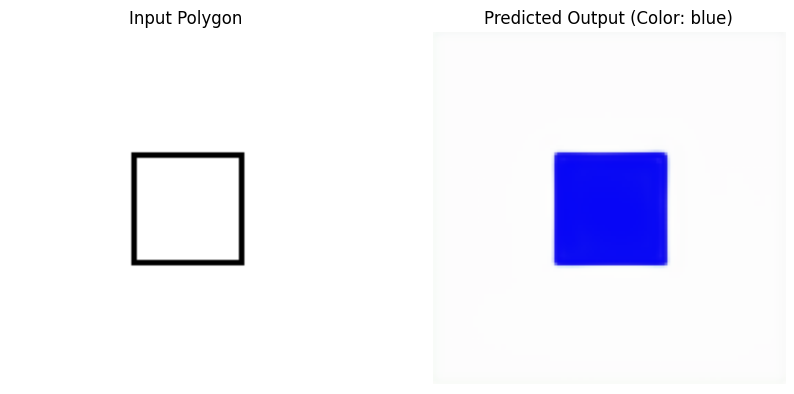

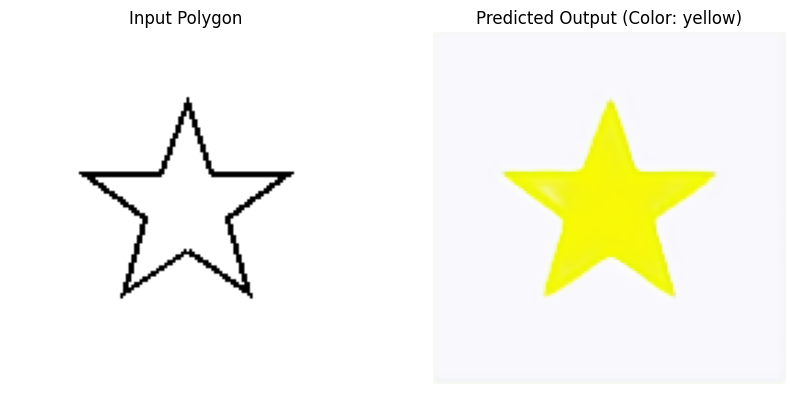

In [15]:
# Running Inference

# Example 1: Square with blue color
input_path_1 = "/content/dataset/dataset/training/inputs/square.png"
color_1 = "blue"

input_tensor_1, color_tensor_1 = preprocess_input(input_path_1, color_1)
with torch.no_grad():
    predicted_output_1 = model((input_tensor_1, color_tensor_1))

visualize_output(input_tensor_1, predicted_output_1, color_1)

# Example 2: Star with yellow color
input_path_2 = "/content/dataset/dataset/training/inputs/star.png"
color_2 = "yellow"

input_tensor_2, color_tensor_2 = preprocess_input(input_path_2, color_2)
with torch.no_grad():
    predicted_output_2 = model((input_tensor_2, color_tensor_2))

visualize_output(input_tensor_2, predicted_output_2, color_2)